# Task4 建模调参

## 4.1 学习目标

* 了解常用的机器学习模型，并掌握机器学习模型的建模与调参流程
* 完成相应学习打卡任务

## 4.2 内容介绍

1. 线性回归模型：
    - 线性回归对于特征的要求；
    - 处理长尾分布；
    - 理解线性回归模型；
2. 模型性能验证：
    - 交叉验证方法；
    - 绘制学习率曲线；
    - 绘制验证曲线；
4. 评估算法模型框架：
5. 模型调参：
  - 贪心算法 https://www.jianshu.com/p/ab89df9759c8
  - 网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029
  - 贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154

## 4.3 相关原理介绍与推荐

由于相关算法原理篇幅较长，本文推荐了一些博客与教材供初学者们进行学习。

### 4.3.1 线性回归模型

https://zhuanlan.zhihu.com/p/49480391

### 4.3.2 决策树模型

https://zhuanlan.zhihu.com/p/65304798

### 4.3.3 GBDT模型

https://zhuanlan.zhihu.com/p/45145899

### 4.3.4 XGBoost模型

https://zhuanlan.zhihu.com/p/86816771

### 4.3.5 LightGBM模型

https://zhuanlan.zhihu.com/p/89360721

### 4.3.6 推荐教材：

   - 《机器学习》 https://book.douban.com/subject/26708119/
   - 《统计学习方法》 https://book.douban.com/subject/10590856/
   - 《Python大战机器学习》 https://book.douban.com/subject/26987890/
   - 《面向机器学习的特征工程》 https://book.douban.com/subject/26826639/
   - 《数据科学家访谈录》 https://book.douban.com/subject/30129410/


## 4.4 代码

In [1]:
# 基础工具
import numpy as np
import pandas as pd
#统计包
import scipy.stats as st
from scipy.special import jn
import warnings
warnings.filterwarnings('ignore')
# 可视化工具包
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']#设置中文字体
pd.set_option('display.max_columns',60) #设置最大显示的列数
## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# 导入xgb、lgb、catboost
import xgboost as xgb
import lightgbm as lgb
import catboost


reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

导入特征工程处理好的数据

In [36]:
# 导入之前处理好的数据
data = reduce_mem_usage(pd.read_csv('futures_select_before.csv'))
data.head()

Memory usage of dataframe is 83199712.00 MB
Memory usage after optimization is: 19800029.00 MB
Decreased by 76.2%


,SaleID,power,kilometer,regionCode,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time0,age,used_days,age_bin,Is_scrap,city,gearbox_count,gearbox_price_max,gearbox_price_median,gearbox_price_min,gearbox_std,gearbox_price_average,brand_price_median,brand_price_mean,brand_price_size,brand_price_std,brand_price_max,brand_price_min,gearbox_0.0,gearbox_1.0,car_class_0,car_class_1,car_class_2,is_fuel_0,is_fuel_1,notRepairedDamage_0.0,notRepairedDamage_1.0,notRepairedDamage_2.0,power_bin,kil_bin,kilometer_s,price
0,0,60,12.5,1046,43.34375,3.966797,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551,1,4385,12.000000,4384.0,3,0,46.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,2800.0,5420.0,10217,7192.0,99900.0,13.0,1,0,1,0,0,0,1,1,0,0,2,4,0.827637,1850.0
1,1,0,15.0,4366,45.31250,5.234375,0.137939,1.380859,-1.421875,0.264893,0.121033,0.135742,0.026596,0.020584,-4.902344,2.095703,-1.030273,-1.722656,0.245483,1,4757,13.000000,4756.0,3,0,366.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,3900.0,6736.0,13794,8100.0,97500.0,15.0,1,0,1,0,0,0,1,0,0,1,0,4,1.000000,3600.0
2,2,163,12.5,2806,45.96875,4.824219,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980,1,4382,12.000000,4384.0,3,0,806.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,4900.0,7156.0,1458,7964.0,89000.0,50.0,1,0,1,0,0,0,1,1,0,0,6,4,0.827637,6222.0
3,3,193,15.0,434,45.68750,4.492188,-0.050629,0.883789,-2.228516,0.274414,0.110291,0.121948,0.033386,0.000000,-4.507812,1.286133,-0.501953,-2.437500,-0.478760,1,7125,19.500000,7124.0,4,1,434.0,32395.0,99999.0,3950.0,13.0,8656.0,7068.0,3790.0,6556.0,14249,7860.0,89000.0,15.0,0,1,0,0,1,0,1,1,0,0,7,4,1.000000,2400.0
4,4,68,5.0,6977,44.37500,2.031250,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,-1.896484,0.910645,0.931152,2.833984,1.923828,1,1531,4.199219,1531.0,1,0,977.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,2980.0,5288.0,4665,7008.0,99999.0,13.0,1,0,1,0,0,0,1,1,0,0,2,1,0.310303,5200.0


In [37]:
data.set_index('SaleID')

,power,kilometer,regionCode,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time0,age,used_days,age_bin,Is_scrap,city,gearbox_count,gearbox_price_max,gearbox_price_median,gearbox_price_min,gearbox_std,gearbox_price_average,brand_price_median,brand_price_mean,brand_price_size,brand_price_std,brand_price_max,brand_price_min,gearbox_0.0,gearbox_1.0,car_class_0,car_class_1,car_class_2,is_fuel_0,is_fuel_1,notRepairedDamage_0.0,notRepairedDamage_1.0,notRepairedDamage_2.0,power_bin,kil_bin,kilometer_s,price
SaleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60,12.5,1046,43.34375,3.966797,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551,1,4385,12.000000,4384.0,3,0,46.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,2800.0,5420.0,10217,7192.0,99900.0,13.0,1,0,1,0,0,0,1,1,0,0,2,4,0.827637,1850.0
1,0,15.0,4366,45.31250,5.234375,0.137939,1.380859,-1.421875,0.264893,0.121033,0.135742,0.026596,0.020584,-4.902344,2.095703,-1.030273,-1.722656,0.245483,1,4757,13.000000,4756.0,3,0,366.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,3900.0,6736.0,13794,8100.0,97500.0,15.0,1,0,1,0,0,0,1,0,0,1,0,4,1.000000,3600.0
2,163,12.5,2806,45.96875,4.824219,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980,1,4382,12.000000,4384.0,3,0,806.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,4900.0,7156.0,1458,7964.0,89000.0,50.0,1,0,1,0,0,0,1,1,0,0,6,4,0.827637,6222.0
3,193,15.0,434,45.68750,4.492188,-0.050629,0.883789,-2.228516,0.274414,0.110291,0.121948,0.033386,0.000000,-4.507812,1.286133,-0.501953,-2.437500,-0.478760,1,7125,19.500000,7124.0,4,1,434.0,32395.0,99999.0,3950.0,13.0,8656.0,7068.0,3790.0,6556.0,14249,7860.0,89000.0,15.0,0,1,0,0,1,0,1,1,0,0,7,4,1.000000,2400.0
4,68,5.0,6977,44.37500,2.031250,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,-1.896484,0.910645,0.931152,2.833984,1.923828,1,1531,4.199219,1531.0,1,0,977.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,2980.0,5288.0,4665,7008.0,99999.0,13.0,1,0,1,0,0,0,1,1,0,0,2,1,0.310303,5200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,116,15.0,3219,45.62500,5.957031,-0.918457,0.774902,-2.021484,0.284668,0.130005,0.049835,0.028809,0.004616,-5.976562,1.302734,-1.207031,-1.981445,-0.357666,0,7261,19.906250,7260.0,4,1,219.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,3800.0,6616.0,16737,7788.0,99999.0,12.0,1,0,0,0,1,0,1,0,0,1,4,4,1.000000,NaN
199996,75,15.0,1857,43.93750,4.476562,-0.841797,1.328125,-1.292969,0.268066,0.108093,0.066040,0.025467,0.025970,-3.914062,1.759766,-2.076172,-1.155273,0.169067,0,6014,16.500000,6016.0,4,1,857.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,3250.0,5788.0,31480,7156.0,99999.0,13.0,1,0,0,0,1,0,1,0,0,1,2,4,1.000000,NaN
199997,224,15.0,3452,46.53125,4.171875,0.388672,-0.704590,-1.480469,0.269531,0.105713,0.117676,0.057465,0.015671,-4.640625,0.654785,1.137695,-1.390625,0.254395,0,4345,11.898438,4344.0,3,0,452.0,32395.0,99999.0,3950.0,13.0,8656.0,7068.0,3900.0,6736.0,13794,8100.0,97500.0,15.0,0,1,0,0,1,0,1,0,0,1,8,4,1.000000,NaN


In [39]:
data.columns

Index(['SaleID', 'power', 'kilometer', 'regionCode', 'v_0', 'v_1', 'v_2',
       'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'train', 'used_time0', 'age', 'used_days', 'age_bin',
       'Is_scrap', 'city', 'gearbox_count', 'gearbox_price_max',
       'gearbox_price_median', 'gearbox_price_min', 'gearbox_std',
       'gearbox_price_average', 'brand_price_median', 'brand_price_mean',
       'brand_price_size', 'brand_price_std', 'brand_price_max',
       'brand_price_min', 'gearbox_0.0', 'gearbox_1.0', 'car_class_0',
       'car_class_1', 'car_class_2', 'is_fuel_0', 'is_fuel_1',
       'notRepairedDamage_0.0', 'notRepairedDamage_1.0',
       'notRepairedDamage_2.0', 'power_bin', 'kil_bin', 'kilometer_s',
       'price'],
      dtype='object')

### 4.4.1线性回归模型

In [40]:
# 然后训练集和测试集分开
train = data[data['train'] == 1]
test = data[data['train'] == 0]  # 这个先不用

# 选择那些数值型的数据特征
continue_fea = [
    'power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
    'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
    'gearbox_price_max', 'gearbox_price_median', 'gearbox_price_min',
    'gearbox_std', 'gearbox_price_average', 'used_time0', 'age',
    'brand_price_median', 'brand_price_mean', 'brand_price_size',
    'brand_price_std', 'brand_price_max', 'brand_price_min'
]
#train_x = train[continue_fea].loc[train['used_days'].notna()]
train_x = train[continue_fea]
train_y = train['price']
test_x = test[continue_fea]

In [41]:
del train['train']
del test['train']       

.fit方法就是训练模型， 训练的结果就是求出了参数然后可以求出预测值

In [42]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(train_x, train_y)
print('intercept: ' + str(model.intercept_))
sorted(dict(zip(continue_fea, model.coef_)).items(), key=lambda x: x[1], reverse=True)

intercept: -61670957000.0


[('v_6', 3383320.5),
 ('v_5', 1758786.4),
 ('gearbox_price_min', 1386723.9),
 ('v_8', 1015267.06),
 ('gearbox_price_max', 616656.0),
 ('v_9', 537710.06),
 ('v_7', 334640.25),
 ('v_10', 34582.77),
 ('v_12', 21173.893),
 ('v_11', 16952.922),
 ('gearbox_price_median', 3252.0168),
 ('v_3', 3192.3489),
 ('gearbox_std', 2431.9543),
 ('v_4', 2147.4736),
 ('v_14', 1128.4636),
 ('power', 18.978043),
 ('brand_price_mean', 2.635958),
 ('used_time0', 0.61127687),
 ('brand_price_std', 0.48608956),
 ('brand_price_size', 0.028682882),
 ('brand_price_max', -0.014147113),
 ('brand_price_median', -3.5784307),
 ('brand_price_min', -5.0741315),
 ('age', -167.02686),
 ('kilometer', -342.97653),
 ('v_0', -3775.066),
 ('v_13', -5818.118),
 ('gearbox_price_average', -6580.207),
 ('v_1', -16568.883),
 ('v_2', -37336.73)]

In [43]:
y_pred = model.predict(test_x)

可以看一下线性回归的训练效果，绘制一下v_1这个特征和标签的散点图：

The predicted price is obvious different from true price


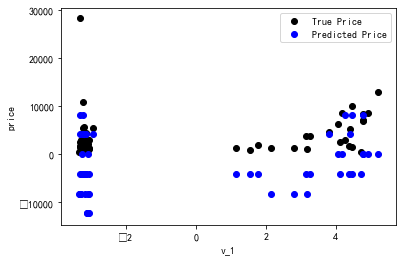

In [44]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)
plt.scatter(train_x['v_1'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_x['v_1'][subsample_index], model.predict(train_x.loc[subsample_index]), color='blue')
plt.xlabel('v_1')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

从上图中我们可以发现发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题。 这个还是需要会看的，从这里我们也可以看出或许price这个需要处理一下。

对price取对数

The transformed price seems like normal distribution


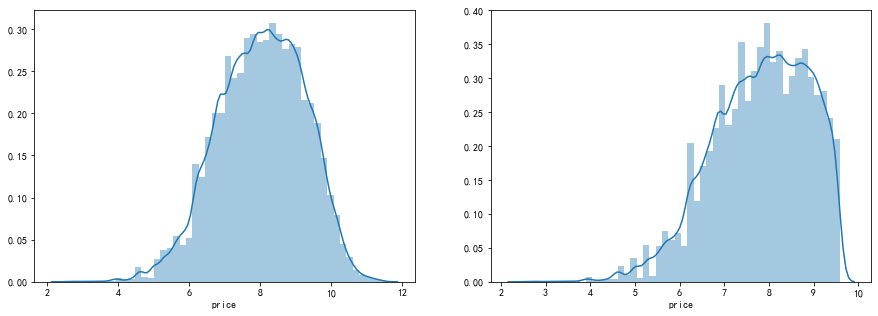

In [45]:
train_y_ln = np.log1p(train_y)
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [46]:
model = model.fit(train_x, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continue_fea, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:2586116.2


[('v_2', 2.2052896),
 ('v_1', 1.8706455),
 ('v_9', 1.7589741),
 ('v_13', 0.53247374),
 ('gearbox_price_average', 0.27591932),
 ('v_14', 0.027091103),
 ('power', 0.0008571606),
 ('brand_price_min', 0.000305995),
 ('used_time0', 8.052974e-05),
 ('brand_price_median', 2.5686053e-05),
 ('brand_price_std', 1.2508054e-05),
 ('brand_price_size', 2.2568504e-06),
 ('brand_price_max', -2.8623185e-07),
 ('brand_price_mean', -1.7984217e-05),
 ('kilometer', -0.008476006),
 ('age', -0.02244612),
 ('v_0', -0.033942442),
 ('gearbox_std', -0.10196263),
 ('gearbox_price_median', -0.13634215),
 ('v_3', -0.51441216),
 ('v_4', -0.5833675),
 ('v_12', -0.93406934),
 ('v_11', -1.284951),
 ('v_10', -1.4013819),
 ('v_7', -3.7004437),
 ('v_5', -21.320751),
 ('gearbox_price_max', -25.858887),
 ('v_8', -42.56734),
 ('gearbox_price_min', -58.138454),
 ('v_6', -203.23251)]

The predicted price is obvious different from true price


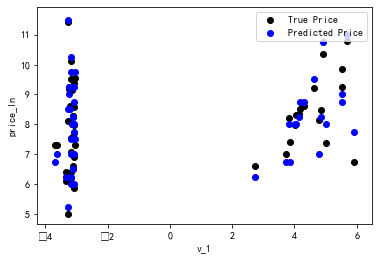

In [47]:
subsample_index = np.random.randint(low=0, high=len(train_y_ln), size=50)
plt.scatter(train_x['v_1'][subsample_index], train_y_ln[subsample_index], color='black')
plt.scatter(train_x['v_1'][subsample_index], model.predict(train_x.loc[subsample_index]), color='blue')
plt.xlabel('v_1')
plt.ylabel('price_ln')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

- 五折交叉验证
> 在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

>因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat))) # 这个是为了解决不合法的值的
        return result
    return wrapper

# 下面是交叉验证
scores = cross_val_score(model, X=train_x, y=train_y, verbose=1, cv=5, scoring=make_scorer(log_transfer(mean_absolute_error)))
# 使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 1.36）
print('AVG:', np.mean(scores))

# 对处理的标签交叉验证
scores = cross_val_score(model, X=train_x, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))
print('AVG:', np.mean(scores))

# 输出五次的验证结果：
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


<function mean_absolute_error at 0x00000245A7A49558> [inf inf inf inf inf]
AVG: inf
AVG: 0.31184485256671907


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


,cv1,cv2,cv3,cv4,cv5
MAE,0.196531,0.197535,0.197004,0.194015,0.774139


#### 评估算法模型的框架

模型选择的时候，可以根据我们数据的特征和优化目标先选出很多个模型作为备选， 因为我们分析完数据不能立刻得出哪个算法对需要解决的问题更有效。
就拿这个比赛来说，我们直观上认为， 由于我们的优化问题是预测价格，这是一个回归问题，我们肯定使用回归模型（Regressor系列）， 但是回归模型太多， 我们又知道部分数据呈线性分布，线性回归算法和正则化的回归算法可能对解决问题比较有效， 由于数据的离散化， 通过决策树算法及相应的集成算法也一般会表现出色， 所以我们可以锁定几个模型都尝试一下。

In [79]:
train1=train.copy()
del train1['used_days']
X = train1.iloc[:, 1:-1]
Y_ln =np.log1p( train1['price'])
Y_ln.head()
test1=test.copy()
del test1['used_days']
X_test =test1.iloc[:, 1:-1]

In [80]:
X_test.head()

,power,kilometer,regionCode,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,used_time0,age,age_bin,Is_scrap,city,gearbox_count,gearbox_price_max,gearbox_price_median,gearbox_price_min,gearbox_std,gearbox_price_average,brand_price_median,brand_price_mean,brand_price_size,brand_price_std,brand_price_max,brand_price_min,gearbox_0.0,gearbox_1.0,car_class_0,car_class_1,car_class_2,is_fuel_0,is_fuel_1,notRepairedDamage_0.0,notRepairedDamage_1.0,notRepairedDamage_2.0,power_bin,kil_bin,kilometer_s
149999,313,15.0,1440,49.59375,5.246094,1.000977,-4.121094,0.737305,0.264404,0.121826,0.070923,0.106567,0.078857,-7.050781,-0.854492,4.800781,0.620117,-3.664062,1569,4.300781,1,0,440.0,32395.0,99999.0,3950.0,13.0,8656.0,7068.0,3800.0,6616.0,16737,7788.0,99999.0,12.0,0,1,0,1,0,0,1,1,0,0,12,4,1.000000
150000,75,12.5,5419,42.40625,-3.253906,-1.753906,3.646484,-0.725586,0.261719,0.000000,0.096741,0.013702,0.052368,3.679688,-0.729004,-3.796875,-1.541016,-0.756836,6262,17.203125,4,1,419.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,3448.0,5560.0,1547,6476.0,95000.0,20.0,1,0,0,0,1,0,1,0,0,1,2,4,0.827637
150001,109,7.0,5045,45.84375,4.703125,0.155396,-1.118164,-0.229126,0.260254,0.112061,0.078064,0.062073,0.050537,-4.925781,1.000977,0.826660,0.138184,0.753906,2561,7.000000,2,0,45.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,3448.0,5560.0,1547,6476.0,95000.0,20.0,1,0,0,0,1,0,1,0,0,1,4,2,0.448242
150002,160,7.0,4023,46.43750,4.320312,0.428955,-2.037109,-0.234741,0.260498,0.106750,0.081116,0.075989,0.048279,-4.863281,0.505371,1.870117,0.365967,1.312500,2181,6.000000,2,0,23.0,32395.0,99999.0,3950.0,13.0,8656.0,7068.0,3250.0,5788.0,31480,7156.0,99999.0,13.0,0,1,0,0,1,0,1,0,0,1,6,2,0.448242
150003,75,15.0,3103,42.18750,-3.166016,-1.572266,2.603516,0.387451,0.250977,0.000000,0.077820,0.028595,0.081726,3.617188,-0.673340,-3.197266,-0.025681,-0.101318,6824,18.703125,4,1,103.0,117603.0,99999.0,3000.0,11.0,7116.0,5608.0,2750.0,5244.0,16089,7044.0,98000.0,14.0,1,0,1,0,0,0,1,0,0,1,2,4,1.000000


In [59]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import KFold

LR: 0.201676 (0.002185)
Ridge: 0.200438 (0.001940)
LASSO: 0.429632 (0.003300)
DecisionTree: 0.196653 (0.001428)
RandomForest: 0.137074 (0.001011)
GradientBoosting: 0.180814 (0.001074)
XGB: 0.145046 (0.000926)
LGB: 0.150126 (0.000615)


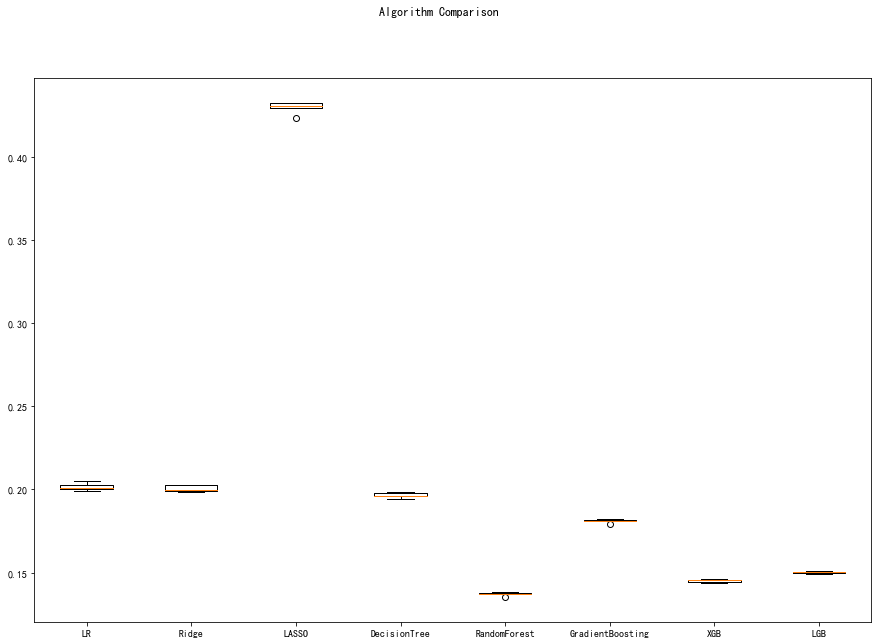

In [60]:
num_folds = 5
seed = 7

# 把所有模型写到一个字典中
models = {}
models['LR'] = LinearRegression()
models['Ridge'] = Ridge()
models['LASSO'] = Lasso()
models['DecisionTree'] = DecisionTreeRegressor()
models['RandomForest'] = RandomForestRegressor()
models['GradientBoosting'] = GradientBoostingRegressor()
models['XGB'] = XGBRegressor(n_estimators = 100, objective='reg:squarederror')
models['LGB'] = LGBMRegressor(n_estimators=100)

results = []
for key in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_result = cross_val_score(models[key], X, Y_ln, cv=kfold, scoring=make_scorer(mean_absolute_error))
    results.append(cv_result)
    print('%s: %f (%f)' % (key, cv_result.mean(), cv_result.std()))
    
# 评估算法 --- 箱线图
fig1 = plt.figure(figsize=(15, 10))
fig1.suptitle('Algorithm Comparison')
ax = fig1.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())
plt.show()


随机森林 xgb lgb表现都不错

#### 模型的调参

模型的调参这里，有三种方式：
>1贪心调参
2网格搜索调参
3贝叶斯调参

只对LGB做的实验，还有个原因就是LGB会很快

In [61]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']
num_leaves = [10, 55, 70, 100, 200]
max_depth = [ 10, 55, 70, 100, 200]
n_estimators = [200, 400, 800, 1000]
learning_rate =  [0.01, 0.05, 0.1, 0.2]


- 贪心调参

拿当前对模型影响最大的参数调优，直到最优化；再拿下一个影响最大的参数调优，如此下去，直到所有的参数调整完毕。这个方法的缺点就是可能会调到局部最优而不是全局最优，但是省时间省力，巨大的优势面前，可以一试。

In [62]:
# 先建立一个参数字典
best_obj = dict()

# 调objective
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X, Y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score

In [63]:
# 上面调好之后，用上面的参数调num_leaves
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X, Y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score


In [64]:
# 用上面两个最优参数调max_depth
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x: x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X, Y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

In [65]:
# 调n_estimators
best_nstimators = dict()
for nstimator in n_estimators:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x: x[1])[0],
                          max_depth=min(best_depth.items(), key=lambda x:x[1])[0],
                          n_estimators=nstimator)
    
    score = np.mean(cross_val_score(model, X, Y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_nstimators[nstimator] = score
 

In [66]:
#调learning_rate
best_lr = dict()
for lr in learning_rate:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x: x[1])[0],
                          max_depth=min(best_depth.items(), key=lambda x:x[1])[0],
                          n_estimators=min(best_nstimators.items(), key=lambda x:x[1])[0],
                          learning_rate=lr)
    score = np.mean(cross_val_score(model, X, Y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_lr[lr] = score

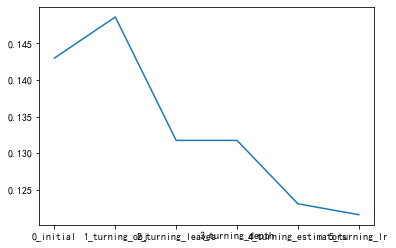

In [67]:
#可视化这个过程的结果
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves',
                '3_turning_depth','4_turning_estimators', '5_turning_lr'],
             y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values()),
               min(best_nstimators.values()), min(best_lr.values())])

In [68]:
#打印最后的调参结果
print("best_obj:", min(best_obj.items(), key=lambda x: x[1]))
print("best_leaves:", min(best_leaves.items(), key=lambda x: x[1]) )
print('best_depth:', min(best_depth.items(), key=lambda x: x[1]))
print('best_nstimators: ', min(best_nstimators.items(), key=lambda x: x[1]))
print('best_lr:', min(best_lr.items(), key=lambda x: x[1]))

best_obj: ('regression_l1', 0.14861447735030592)
best_leaves: (200, 0.1317658773883902)
best_depth: (55, 0.1317658773883902)
best_nstimators:  (1000, 0.12310572049897858)
best_lr: (0.05, 0.12162272336624735)


- 网格搜索调参

GridSearchCV，它存在的意义就是自动调参，只要把参数输进去，就能给出最优化的结果和参数。但是这个方法适合于小数据集，一旦数据的量级上去了，很难得出结果。这个在这里面优势不大， 因为数据集很大，不太能跑出结果，但是也整理一下，有时候还是很好用的。

In [ ]:
from sklearn.model_selection import GridSearchCV

# 这个我这边电脑运行时间太长，先不跑了
parameters = {'objective':objective, 'num_leaves':num_leaves, 'max_depth':max_depth,
             'n_estimators': n_estimators, 'learning_rate':learning_rate}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(X, Y_ln)

# 输出最优参数
clf.best_params_

- 贝叶斯调参

贝叶斯优化用于机器学习调参，主要思想是，给定优化的目标函数(广义的函数，只需指定输入和输出即可，无需知道内部结构以及数学性质)，通过不断地添加样本点来更新目标函数的后验分布(高斯过程,直到后验分布基本贴合于真实分布。简单的说，就是考虑了上一次参数的信息，从而更好的调整当前的参数。

>与常规的网格搜索或者随机搜索的区别是：

贝叶斯调参采用高斯过程，考虑之前的参数信息，不断地更新先验；网格搜索未考虑之前的参数信息
贝叶斯调参迭代次数少，速度快；网格搜索速度慢,参数多时易导致维度爆炸
贝叶斯调参针对非凸问题依然稳健；网格搜索针对非凸问题易得到局部最优


In [70]:
from  bayes_opt import BayesianOptimization

# 定义优化函数
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    model = LGBMRegressor(objective='regression_l1', num_leaves=int(num_leaves),
                         max_depth=int(max_depth), subsample=subsample,
                         min_child_samples = int(min_child_samples))
    val = cross_val_score(model, X, Y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)).mean()
    
    return 1-val

# 定义优化参数
rf_bo = BayesianOptimization(
    rf_cv, 
    {
        'num_leaves':(2, 100),
        'max_depth':(2, 100),
        'subsample':(0.1, 1),
        'min_child_samples':(2, 100)
    }
)

#开始优化
num_iter = 25
init_points = 5
rf_bo.maximize(init_points=init_points,n_iter=num_iter)


|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8629   |  43.88    |  42.8     |  93.1     |  0.8775   |
|  2        |  0.8547   |  17.32    |  81.68    |  40.41    |  0.5253   |
|  3        |  0.8372   |  83.38    |  46.09    |  13.19    |  0.5199   |
|  4        |  0.8626   |  30.43    |  73.53    |  87.53    |  0.786    |
|  5        |  0.8628   |  86.54    |  11.11    |  91.12    |  0.1857   |
|  6        |  0.799    |  2.019    |  3.05     |  93.38    |  0.343    |
|  7        |  0.8628   |  83.91    |  9.179    |  89.06    |  0.5414   |
|  8        |  0.8623   |  98.05    |  99.46    |  87.74    |  0.5902   |
|  9        |  0.7619   |  51.81    |  99.02    |  2.698    |  0.9536   |
|  10       |  0.7928   |  5.411    |  2.326    |  3.276    |  0.4913   |
|  11       |  0.8601   |  99.18    |  53.62    |  66.97    |  0.6488   |
|  12       |  0.8184   |  98.02    | 

TypeError: list indices must be integers or slices, not str

### 绘制学习曲线与验证曲线

学习曲线的绘制就是一个非常好的方式， 可以帮助我们看一下我们调试好的模型还有没有过拟合或者欠拟合的问题， 好帮助我们进行下一步的工作。

关于学习曲线：

学习曲线是不同训练集大小，模型在训练集和验证集上的得分变化曲线。
学习曲线图的横坐标是x_train的数据量，纵坐标是对应的train_score, test_score。随着训练样本的逐渐增加，算法练出的模型的表现能力；

In [71]:
from sklearn.model_selection import learning_curve, validation_curve

<module 'matplotlib.pyplot' from 'D:\\Program Files\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

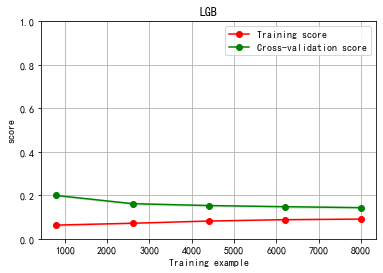

In [83]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_size=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

# 假设已经调好了LGB的参数，我们可以绘制一下曲线看看这个模型有没有什么问题
model = LGBMRegressor(n_estimators=1000, leaves=200, learning_rate=0.05, objective='regression_l1')
model.fit(X, Y_ln)
pred2 = model.predict(X_test)
#print("mae: ", mean_absolute_error(Ytrue, np.expm1(pred2)))

# 画出学习曲线
plot_learning_curve(model, 'LGB', X[:10000], Y_ln[:10000], ylim=(0.0, 1), cv=5, n_jobs=1) 


### 验证曲线

验证曲线和学习曲线很相近，不同的是这里画出的是不同参数下模型的准确率而不是不同训练集大小下的准确率。 这个用的不多，

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


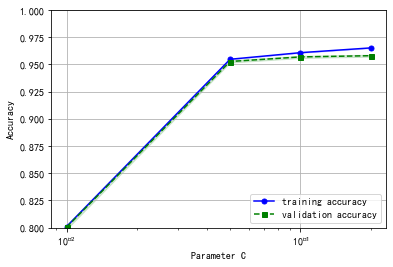

In [84]:
from sklearn.model_selection import validation_curve

param_range =  [0.01, 0.05, 0.1, 0.2]
model = LGBMRegressor()
train_scores, test_scores = validation_curve(model, X, Y_ln, param_name='learning_rate', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()


那么如果模型真的出现了过拟合或者欠拟合，我们应该怎么解决呢？

对于欠拟合，也就是高偏差的问题，这时候可以尝试增加更多的特征， 好好做做特征工程那块，尽量挖掘更多的信息， 在模型上也可以下功夫，加大模型的复杂度， 减少正则化的系数等。boosting方式可以有效的减少模型的欠拟合。

对于过拟合，也就是高方差的问题，我们可以尝试增加数据样本的数量，去掉一些噪声数据， 或者减少特征数量（这个其实不推荐），或者引入正则化的方式。 在模型上也可以下功夫，比如树模型，我们可以减少树的深度，减少模型的复杂度。 对于随机森林可以有效的减少模型的过拟合。
低偏差，高方差，该如何权衡？ 先保证低偏差，这样得到模型在测试集上的最优得分，再调整高方差。
